# Toy Cars Detection using Transfer Learning

We use a pretrained dashcamnet model to do transfer learning on toy cars.

<img align="center" src="https://media.istockphoto.com/photos/hands-of-little-child-boy-playing-with-multicolored-toy-cars-on-white-picture-id1316414600?b=1&k=20&m=1316414600&s=170667a&w=0&h=JeeKZDWvj_JCg077gcuRnto1P3XGiLnIYB_oVIbs7-Q=" width="500"> 

## 1. Set up env variables and map drives
- `$LOCAL_PROJECT_DIR` = `/home/stud22034803/assignment`
- `LOCAL_DATA_DIR` = `$LOCAL_PROJECT_DIR/data` i.e. where data will be stored.
- `LOCAL_EXPERIMENT_DIR` = `$LOCAL_PROJECT_DIR/detectnet_v2` i.e. where TAO experiment generated collaterals will be output.
- `LOCAL_SPECS_DIR` = `$LOCAL_PROJECT_DIR/detectnet_v2/specs` i.e. where specification files are stored.

*Note:* 
- Remove unwanted files in `$USER_EXPERIMENT_DIR` or `$DATA_DOWNLOAD_DIR` that may have been generated from previous experiments.
- Having checkpoint files etc may interfere with creating a training graph for a new experiment.
- Default set up to run training using 1 GPU.

In [1]:
# Setting up env variables for cleaner command line commands.
import os

%env KEY=tlt_encode
%env GPU_INDEX=0
%env MIG_INDEX=device=4:0
%env NUM_GPUS=1

# Set docker root directory
%env USER_EXPERIMENT_DIR=/workspace/toy_car_detection/detectnet_v2
%env DATA_DOWNLOAD_DIR=/workspace/toy_car_detection/data
%env SPECS_DIR=/workspace/toy_car_detection/detectnet_v2/specs

os.environ['UID'] = str(os.getuid())

# Local project directory 
os.environ["LOCAL_PROJECT_DIR"] = '/home/stud22034803/assignment/toy_car_detection'

os.environ["LOCAL_DATA_DIR"] = os.path.join(
    os.getenv("LOCAL_PROJECT_DIR", os.getcwd()),
    "data"
)
os.environ["LOCAL_EXPERIMENT_DIR"] = os.path.join(
    os.getenv("LOCAL_PROJECT_DIR", os.getcwd()),
    "detectnet_v2"
)

# The sample spec files are present in the same path as the downloaded samples.
os.environ["LOCAL_SPECS_DIR"] = os.path.join(
    os.getenv("LOCAL_PROJECT_DIR", os.getcwd()),
    "detectnet_v2/specs"
)

# Showing list of specification files.
!ls -rlt $LOCAL_SPECS_DIR

env: KEY=tlt_encode
env: GPU_INDEX=0
env: MIG_INDEX=device=4:0
env: NUM_GPUS=1
env: USER_EXPERIMENT_DIR=/workspace/toy_car_detection/detectnet_v2
env: DATA_DOWNLOAD_DIR=/workspace/toy_car_detection/data
env: SPECS_DIR=/workspace/toy_car_detection/detectnet_v2/specs
total 48
-rw-rw-r-- 1 stud22034803 stud22034803 5581 Jul  9 12:59 detectnet_v2_retrain_resnet18_kitti_qat.txt
-rw-rw-r-- 1 stud22034803 stud22034803 2432 Jul  9 12:59 detectnet_v2_inference_kitti_etlt_qat.txt
-rw-rw-r-- 1 stud22034803 stud22034803 2423 Jul  9 12:59 detectnet_v2_inference_kitti_etlt.txt
-rw-rw-r-- 1 stud22034803 stud22034803  310 Jul  9 14:12 detectnet_v2_tfrecords_kitti_trainval.txt.save
-rw-rw-r-- 1 stud22034803 stud22034803  304 Jul  9 14:29 detectnet_v2_tfrecords_kitti_trainval.txt
-rw-rw-r-- 1 stud22034803 stud22034803 5554 Jul  9 17:50 detectnet_v2_train_resnet18_kitti.txt
-rw-rw-r-- 1 stud22034803 stud22034803 5583 Jul  9 18:22 detectnet_v2_retrain_resnet18_kitti.txt
-rw-rw-r-- 1 stud22034803 stud22034

In [2]:
# Mapping up the local directories to the TAO docker.
import json
mounts_file = os.path.expanduser("~/.tao_mounts.json")

# Define the dictionary with the mapped drives
drive_map = {
    "Mounts": [
        # Mapping the data directory
        
        {
            "source": os.environ["LOCAL_DATA_DIR"],
            "destination": "/workspace/toy_car_detection/data"
        },
        # Mapping project directory 
        
        {
            "source": os.environ["LOCAL_PROJECT_DIR"],
            "destination": "/workspace/toy_car_detection"
        },
        # Mapping the specs directory.
        {
            "source": os.environ["LOCAL_SPECS_DIR"],
            "destination": os.environ["SPECS_DIR"]
        },
    ],
    "DockerOptions": {
        "user": "{}:{}".format(os.getuid(), os.getgid())
    },
    # set gpu index for tao-converter
    "Envs": [
        {"variable": "CUDA_VISIBLE_DEVICES", "value": os.getenv("MIG_UUID")}
    ]
}

# Writing the mounts file.
with open(mounts_file, "w") as mfile:
    json.dump(drive_map, mfile, indent=4)

!cat ~/.tao_mounts.json

{
    "Mounts": [
        {
            "source": "/home/stud22034803/assignment/toy_car_detection/data",
            "destination": "/workspace/toy_car_detection/data"
        },
        {
            "source": "/home/stud22034803/assignment/toy_car_detection",
            "destination": "/workspace/toy_car_detection"
        },
        {
            "source": "/home/stud22034803/assignment/toy_car_detection/detectnet_v2/specs",
            "destination": "/workspace/toy_car_detection/detectnet_v2/specs"
        }
    ],
    "DockerOptions": {
        "user": "1035:1035"
    },
    "Envs": [
        {
            "variable": "CUDA_VISIBLE_DEVICES",
            "value": null
        }
    ]
}

## 2. Prepare dataset and pre-trained model
- We use [Object Detection:Batteries, Dice, and Toy Cars](https://www.kaggle.com/datasets/markcsizmadia/object-detection-batteries-dices-and-toy-cars) image set from kaggle.
- Total of 495 toy car images were extracted from the initial 1644 images in the dataset, which are further divided into test and train data set:
    - Training images in `$LOCAL_DATA_DIR/train/image`
    - Training labels in `$LOCAL_DATA_DIR/train/label`
    - testing images in `$LOCAL_DATA_DIR/test/image`

*Note: There are no labels for the testing images, therefore we use it just to visualize inferences for the trained model.*

In [3]:
# Check if each image has a corresponding kitti label
filepath_im = os.sep.join(['toy_car_detection', 'data', 'train', 'image'])
filepath_lb = os.sep.join(['toy_car_detection', 'data', 'train', 'label'])

train_image_list = os.listdir(filepath_im)
train_label_list = os.listdir(filepath_lb)

for i, file in enumerate(train_image_list):
    for text in train_label_list:
        if file.split('.')[0] == text.split('.')[0]:
            print("{}) {} : {}".format(i+1, file, text))
            break


1) 00000664.jpg : 00000664.txt
2) 00000535.jpg : 00000535.txt
3) 00000582.jpg : 00000582.txt
4) 00000559.jpg : 00000559.txt
5) 00000634.jpg : 00000634.txt
6) 00000478.jpg : 00000478.txt
7) 00000445.jpg : 00000445.txt
8) 00000318.jpg : 00000318.txt
9) 00000609.jpg : 00000609.txt
10) 00000463.jpg : 00000463.txt
11) 00000483.jpg : 00000483.txt
12) 00000637.jpg : 00000637.txt
13) 00000345.jpg : 00000345.txt
14) 00000604.jpg : 00000604.txt
15) 00000686.jpg : 00000686.txt
16) 00000304.jpg : 00000304.txt
17) 00000698.jpg : 00000698.txt
18) 00000317.jpg : 00000317.txt
19) 00000419.jpg : 00000419.txt
20) 00000576.jpg : 00000576.txt
21) 00000626.jpg : 00000626.txt
22) 00000409.jpg : 00000409.txt
23) 00000699.jpg : 00000699.txt
24) 00000511.jpg : 00000511.txt
25) 00000691.jpg : 00000691.txt
26) 00000689.jpg : 00000689.txt
27) 00000336.jpg : 00000336.txt
28) 00000300.jpg : 00000300.txt
29) 00002876.jpg : 00002876.txt
30) 00000328.jpg : 00000328.txt
31) 00000556.jpg : 00000556.txt
32) 00000550.jpg 

In [4]:
# verify
import os

DATA_DIR = os.environ.get('LOCAL_DATA_DIR')
num_training_images = len(os.listdir(os.path.join(DATA_DIR, "train/image")))
num_training_labels = len(os.listdir(os.path.join(DATA_DIR, "train/label")))
num_testing_images = len(os.listdir(os.path.join(DATA_DIR, "test/image")))
print("Number of images in the train/val set. {}".format(num_training_images))
print("Number of labels in the train/val set. {}".format(num_training_labels))
print("Number of images in the test set. {}".format(num_testing_images))

Number of images in the train/val set. 480
Number of labels in the train/val set. 480
Number of images in the test set. 15


In [5]:
# Sample kitti label.
!cat $LOCAL_DATA_DIR/train/label/00000360.txt

toycar 0.0 0 0.0 141 128 421 264 0.0 0.0 0.0 0.0 0.0 0.0 0.0
toycar 0.0 0 0.0 273 68 513 182 0.0 0.0 0.0 0.0 0.0 0.0 0.0


### C. Prepare tf records from kitti format dataset
- Update the tfrecords spec file to take in your kitti format dataset
- Create the tfrecords using the detectnet_v2 dataset_convert 

*Note: TfRecords only need to be generated once.*

In [6]:
!echo $LOCAL_SPECS_DIR

/home/stud22034803/assignment/toy_car_detection/detectnet_v2/specs


In [9]:
print("TFrecords conversion spec file for kitti training")
!cat $LOCAL_SPECS_DIR/detectnet_v2_tfrecords_kitti_trainval.txt

TFrecords conversion spec file for kitti training
kitti_config {
  root_directory_path: "/workspace/toy_car_detection/data/train"
  image_dir_name: "image"
  label_dir_name: "label"
  image_extension: ".jpg"
  partition_mode: "random"
  num_partitions: 2
  val_split: 15
  num_shards: 10
}
image_directory_path: "/workspace/toy_car_detection/data/train"


In [10]:
# Creating a new directory for the output tfrecords dump.
print("Converting Tfrecords for kitti trainval dataset")

!docker run -it --rm --gpus $MIG_INDEX --name tao_exp_$USER \
-u $UID:$UID \
-v $LOCAL_DATA_DIR:/workspace/toy_car_detection/data \
-v $LOCAL_PROJECT_DIR:/workspace/toy_car_detection \
-v $LOCAL_SPECS_DIR:$SPECS_DIR \
nvcr.io/nvidia/tao/tao-toolkit-tf:v3.21.11-tf1.15.4-py3 \
detectnet_v2 dataset_convert --gpu_index $GPU_INDEX \
    -d $SPECS_DIR/detectnet_v2_tfrecords_kitti_trainval.txt \
    -o $DATA_DOWNLOAD_DIR/tfrecords/kitti_trainval/kitti_trainval

Converting Tfrecords for kitti trainval dataset
mkdir: cannot create directory ‘/opt/ngccli’: Permission denied
Matplotlib created a temporary config/cache directory at /tmp/matplotlib-v9icj07b because the default path (/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.
Using TensorFlow backend.
Using TensorFlow backend.
2022-07-09 06:30:25,225 [INFO] iva.detectnet_v2.dataio.build_converter: Instantiating a kitti converter
2022-07-09 06:30:25,225 [INFO] root: Instantiating a kitti converter
2022-07-09 06:30:25,225 [INFO] root: Generating partitions
2022-07-09 06:30:25,226 [INFO] iva.detectnet_v2.dataio.kitti_converter_lib: Num images in
Train: 408	Val: 72
2022-07-09 06:30:25,227 [INFO] root: Num images in
Train: 408	Val: 72
2022-07-09 06:30:25,227 [INFO] iva.detectnet_v2.dataio.kitti_converter_lib: Valida

In [11]:
!ls -rlt $LOCAL_DATA_DIR/tfrecords/kitti_trainval/

total 364
-rw-r--r-- 1 stud22034803 stud22034803  4350 Jul  9 14:30 kitti_trainval-fold-000-of-002-shard-00000-of-00010
-rw-r--r-- 1 stud22034803 stud22034803  4350 Jul  9 14:30 kitti_trainval-fold-000-of-002-shard-00001-of-00010
-rw-r--r-- 1 stud22034803 stud22034803  4228 Jul  9 14:30 kitti_trainval-fold-000-of-002-shard-00002-of-00010
-rw-r--r-- 1 stud22034803 stud22034803  4228 Jul  9 14:30 kitti_trainval-fold-000-of-002-shard-00003-of-00010
-rw-r--r-- 1 stud22034803 stud22034803  4777 Jul  9 14:30 kitti_trainval-fold-000-of-002-shard-00004-of-00010
-rw-r--r-- 1 stud22034803 stud22034803  4472 Jul  9 14:30 kitti_trainval-fold-000-of-002-shard-00005-of-00010
-rw-r--r-- 1 stud22034803 stud22034803  4533 Jul  9 14:30 kitti_trainval-fold-000-of-002-shard-00006-of-00010
-rw-r--r-- 1 stud22034803 stud22034803  4289 Jul  9 14:30 kitti_trainval-fold-000-of-002-shard-00007-of-00010
-rw-r--r-- 1 stud22034803 stud22034803  4350 Jul  9 14:30 kitti_trainval-fold-000-of-002-shard-00008-of-00010


### D. Download pre-trained model
- Dashcamnet uses detectnet_v2 with resnet18 as backbone; therefore download model templates from `nvidia/tao/pretrained_detectnet_v2 for optimum result.


In [13]:
# Installing NGC CLI on the local machine.
## Download and install
%env CLI=ngccli_cat_linux.zip
!mkdir -p $LOCAL_PROJECT_DIR/ngccli

# Remove any previously existing CLI installations
!rm -rf $LOCAL_PROJECT_DIR/ngccli/*
!wget "https://ngc.nvidia.com/downloads/$CLI" -P $LOCAL_PROJECT_DIR/ngccli
!unzip -u "$LOCAL_PROJECT_DIR/ngccli/$CLI" -d $LOCAL_PROJECT_DIR/ngccli/
!rm $LOCAL_PROJECT_DIR/ngccli/*.zip 
os.environ["PATH"]="{}/ngccli:{}".format(os.getenv("LOCAL_PROJECT_DIR", ""), os.getenv("PATH", ""))

env: CLI=ngccli_cat_linux.zip
--2022-07-09 14:32:42--  https://ngc.nvidia.com/downloads/ngccli_cat_linux.zip
Resolving ngc.nvidia.com (ngc.nvidia.com)... 54.192.150.92, 54.192.150.72, 54.192.150.94, ...
Connecting to ngc.nvidia.com (ngc.nvidia.com)|54.192.150.92|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 33924412 (32M) [application/zip]
Saving to: ‘/home/stud22034803/assignment/toy_car_detection/ngccli/ngccli_cat_linux.zip’

ngccli_cat_linux.zi 100%[===================>]  32.35M  98.0MB/s    in 0.3s    

2022-07-09 14:32:43 (98.0 MB/s) - ‘/home/stud22034803/assignment/toy_car_detection/ngccli/ngccli_cat_linux.zip’ saved [33924412/33924412]

Archive:  /home/stud22034803/assignment/toy_car_detection/ngccli/ngccli_cat_linux.zip
   creating: /home/stud22034803/assignment/toy_car_detection/ngccli/ngc-cli/
   creating: /home/stud22034803/assignment/toy_car_detection/ngccli/ngc-cli/yarl/
  inflating: /home/stud22034803/assignment/toy_car_detection/ngccli/ngc-cli

In [14]:
# List models available in the model registry.
!ngc registry model list nvidia/tao/pretrained_detectnet_v2:*

+-------+-------+-------+-------+-------+-------+-------+-------+-------+
| Versi | Accur | Epoch | Batch | GPU   | Memor | File  | Statu | Creat |
| on    | acy   | s     | Size  | Model | y Foo | Size  | s     | ed    |
|       |       |       |       |       | tprin |       |       | Date  |
|       |       |       |       |       | t     |       |       |       |
+-------+-------+-------+-------+-------+-------+-------+-------+-------+
| vgg19 | 82.6  | 80    | 1     | V100  | 153.8 | 153.7 | UPLOA | Aug   |
|       |       |       |       |       |       | 7 MB  | D_COM | 24,   |
|       |       |       |       |       |       |       | PLETE | 2021  |
| vgg16 | 82.2  | 80    | 1     | V100  | 113.2 | 113.2 | UPLOA | Aug   |
|       |       |       |       |       |       | MB    | D_COM | 24,   |
|       |       |       |       |       |       |       | PLETE | 2021  |
| squee | 65.67 | 80    | 1     | V100  | 6.5   | 6.46  | UPLOA | Aug   |
| zenet |       |       |       |     

In [15]:
# Create the target destination to download the model.
!mkdir -p $LOCAL_EXPERIMENT_DIR/pretrained_resnet18/

In [16]:
# Download the pretrained model from NGC
!ngc registry model download-version nvidia/tao/pretrained_detectnet_v2:resnet18 \
    --dest $LOCAL_EXPERIMENT_DIR/pretrained_resnet18

Downloaded 82.28 MB in 8m 9s, Download speed: 172.11 KB/s                
----------------------------------------------------
Transfer id: pretrained_detectnet_v2_vresnet18 Download status: Completed.
Downloaded local path: /home/stud22034803/assignment/toy_car_detection/detectnet_v2/pretrained_resnet18/pretrained_detectnet_v2_vresnet18
Total files downloaded: 1 
Total downloaded size: 82.28 MB
Started at: 2022-07-09 14:34:06.466015
Completed at: 2022-07-09 14:42:15.986179
Duration taken: 8m 9s
----------------------------------------------------


In [47]:
!ls -rlt $LOCAL_EXPERIMENT_DIR/pretrained_resnet18/pretrained_detectnet_v2_vresnet18

total 91164
-rw------- 1 stud22034803 stud22034803 93345248 Jul  9 14:42 resnet18.hdf5


## 3. Provide training specification
- Tfrecords for the train datasets
    - To use the newly generated tfrecords, update the dataset_config parameter in the spec file at `$SPECS_DIR/detectnet_v2_train_resnet18_kitti.txt` 
    - Update the fold number to use for evaluation. In case of random data split, please use fold `0` only
    - For sequence-wise split, you may use any fold generated from the dataset convert tool
- Pre-trained models
- Augmentation parameters for on the fly data augmentation
- Other training (hyper-)parameters such as batch size, number of epochs, learning rate etc.

In [62]:
!cat $LOCAL_SPECS_DIR/detectnet_v2_train_resnet18_kitti.txt

random_seed: 42
dataset_config {
  data_sources {
    tfrecords_path: "/workspace/toy_car_detection/data/tfrecords/kitti_trainval/*"
    image_directory_path: "/workspace/toy_car_detection/data/train"
  }
  image_extension: "jpg"
  target_class_mapping {
    key: "toycar"
    value: "toycar"
  }
  target_class_mapping {
    key: "cyclist"
    value: "cyclist"
  }
  target_class_mapping {
    key: "pedestrian"
    value: "pedestrian"
  }
  target_class_mapping {
    key: "person_sitting"
    value: "pedestrian"
  }
  target_class_mapping {
    key: "van"
    value: "toycar"
  }
  validation_fold: 0
}
augmentation_config {
  preprocessing {
    output_image_width: 640
    output_image_height: 640
    min_bbox_width: 1.0
    min_bbox_height: 1.0
    output_image_channel: 3
  }
  spatial_augmentation {
    hflip_probability: 0.5
    zoom_min: 1.0
    zoom_max: 1.0
    translate_max_x: 8.0
    translate_max_y: 8.0
  }
  color_augmentation {
    hue_rotation_max: 25.0
    saturation_shift_ma

## 4. Run TAO training

In [65]:
!docker run -it --rm --gpus $MIG_INDEX --name tao_exp_$USER \
-u $UID:$UID \
-v $LOCAL_DATA_DIR:/workspace/toy_car_detection/data \
-v $LOCAL_PROJECT_DIR:/workspace/toy_car_detection \
-v $LOCAL_SPECS_DIR:$SPECS_DIR \
nvcr.io/nvidia/tao/tao-toolkit-tf:v3.21.11-tf1.15.4-py3 \
detectnet_v2 train -e $SPECS_DIR/detectnet_v2_train_resnet18_kitti.txt \
    -r $USER_EXPERIMENT_DIR/experiment_dir_unpruned \
    -k $KEY \
    -n resnet18_detector \
    --gpu_index $GPU_INDEX

mkdir: cannot create directory ‘/opt/ngccli’: Permission denied
Matplotlib created a temporary config/cache directory at /tmp/matplotlib-9yo6gjj_ because the default path (/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.
Using TensorFlow backend.
Using TensorFlow backend.

2022-07-09 09:52:13,712 [WARNING] tensorflow: From /opt/tlt/.cache/dazel/_dazel_tlt/75913d2aee35770fa76c4a63d877f3aa/execroot/ai_infra/bazel-out/k8-fastbuild/bin/magnet/packages/iva/build_wheel.runfiles/ai_infra/iva/detectnet_v2/cost_function/cost_auto_weight_hook.py:43: The name tf.train.SessionRunHook is deprecated. Please use tf.estimator.SessionRunHook instead.


2022-07-09 09:52:13,827 [WARNING] tensorflow: From /opt/tlt/.cache/dazel/_dazel_tlt/75913d2aee35770fa76c4a63d877f3aa/execroot/ai_infra/bazel-out/k8-fastbuild/bin/magnet/p

In [66]:
print('Model for each epoch:')
print('---------------------')
!ls -lh $LOCAL_EXPERIMENT_DIR/experiment_dir_unpruned/weights

Model for each epoch:
---------------------
total 43M
-rw-r--r-- 1 stud22034803 stud22034803 43M Jul  9 18:09 resnet18_detector.tlt


## 5. Evaluate the trained model

In [67]:
!docker run -it --rm --gpus $MIG_INDEX --name tao_exp_$USER \
-u $UID:$UID \
-v $LOCAL_DATA_DIR:/workspace/toy_car_detection/data \
-v $LOCAL_PROJECT_DIR:/workspace/toy_car_detection \
-v $LOCAL_SPECS_DIR:$SPECS_DIR \
nvcr.io/nvidia/tao/tao-toolkit-tf:v3.21.11-tf1.15.4-py3 \
detectnet_v2 evaluate --gpu_index $GPU_INDEX \
    -e $SPECS_DIR/detectnet_v2_train_resnet18_kitti.txt\
    -m $USER_EXPERIMENT_DIR/experiment_dir_unpruned/weights/resnet18_detector.tlt \
    -k $KEY

mkdir: cannot create directory ‘/opt/ngccli’: Permission denied
Matplotlib created a temporary config/cache directory at /tmp/matplotlib-e52wo0v4 because the default path (/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.
Using TensorFlow backend.
Using TensorFlow backend.

2022-07-09 10:15:41,066 [WARNING] tensorflow: From /opt/tlt/.cache/dazel/_dazel_tlt/75913d2aee35770fa76c4a63d877f3aa/execroot/ai_infra/bazel-out/k8-fastbuild/bin/magnet/packages/iva/build_wheel.runfiles/ai_infra/iva/detectnet_v2/cost_function/cost_auto_weight_hook.py:43: The name tf.train.SessionRunHook is deprecated. Please use tf.estimator.SessionRunHook instead.

2022-07-09 10:15:41,180 [INFO] iva.detectnet_v2.spec_handler.spec_loader: Merging specification from /workspace/toy_car_detection/detectnet_v2/specs/detectnet_v2_train_res

## 6. Prune the trained model
- Specify pre-trained model
- Equalization criterion (`Applicable for resnets and mobilenets`)
- Threshold for pruning.
- A key to save and load the model
- Output directory to store the model

In [84]:
# Create an output directory if it doesn't exist.
!mkdir -p $LOCAL_EXPERIMENT_DIR/experiment_dir_pruned

In [85]:
!docker run -it --rm --gpus $MIG_INDEX --name tao_exp_$USER \
-u $UID:$UID \
-v $LOCAL_DATA_DIR:/workspace/toy_car_detection/data \
-v $LOCAL_PROJECT_DIR:/workspace/toy_car_detection \
-v $LOCAL_SPECS_DIR:$SPECS_DIR \
nvcr.io/nvidia/tao/tao-toolkit-tf:v3.21.11-tf1.15.4-py3 \
detectnet_v2 prune --gpu_index $GPU_INDEX \
    -m $USER_EXPERIMENT_DIR/experiment_dir_unpruned/weights/resnet18_detector.tlt \
    -o $USER_EXPERIMENT_DIR/experiment_dir_pruned/resnet18_nopool_bn_detectnet_v2_pruned.tlt \
    -eq union \
    -pth 0.5 \
    -k $KEY


mkdir: cannot create directory ‘/opt/ngccli’: Permission denied
Matplotlib created a temporary config/cache directory at /tmp/matplotlib-1d50lsdk because the default path (/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.
Using TensorFlow backend.
Using TensorFlow backend.
2022-07-09 11:16:00,949 [INFO] modulus.pruning.pruning: Exploring graph for retainable indices
2022-07-09 11:16:01,403 [INFO] modulus.pruning.pruning: Pruning model and appending pruned nodes to new graph
2022-07-09 11:16:13,341 [INFO] iva.common.magnet_prune: Pruning ratio (pruned model / original model): 0.4882124226648468
2022-07-09 11:16:13,613 [INFO] root: Pruning ratio (pruned model / original model): 0.4882124226648468
2022-07-09 11:16:13,613 [INFO] root: {
    "pruning_ratio": 0.4882124226648468,
    "size": 21.064674377441406,

In [86]:
!ls -rlt $LOCAL_EXPERIMENT_DIR/experiment_dir_pruned/

total 21576
-rw-r--r-- 1 stud22034803 stud22034803 22087912 Jul  9 19:16 resnet18_nopool_bn_detectnet_v2_pruned.tlt


## 7. Retrain the pruned model
- Model needs to be re-trained to bring back accuracy after pruning
- Specify re-training specification with pretrained weights as pruned model.

In [87]:
# Printing the retrain experiment file. 
# Note: We have updated the experiment file to include the 
# newly pruned model as a pretrained weights and, the
# load_graph option is set to true 
!cat $LOCAL_SPECS_DIR/detectnet_v2_retrain_resnet18_kitti.txt

random_seed: 42
dataset_config {
  data_sources {
    tfrecords_path: "/workspace/toy_car_detection/data/tfrecords/kitti_trainval/*"
    image_directory_path: "/workspace/toy_car_detection/data/train"
  }
  image_extension: "jpg"
  target_class_mapping {
    key: "toycar"
    value: "toycar"
  }
  target_class_mapping {
    key: "cyclist"
    value: "cyclist"
  }
  target_class_mapping {
    key: "pedestrian"
    value: "pedestrian"
  }
  target_class_mapping {
    key: "person_sitting"
    value: "pedestrian"
  }
  target_class_mapping {
    key: "van"
    value: "toycar"
  }
  validation_fold: 0
}
augmentation_config {
  preprocessing {
    output_image_width: 640
    output_image_height: 640
    min_bbox_width: 1.0
    min_bbox_height: 1.0
    output_image_channel: 3
  }
  spatial_augmentation {
    hflip_probability: 0.5
    zoom_min: 1.0
    zoom_max: 1.0
    translate_max_x: 8.0
    translate_max_y: 8.0
  }
  color_augmentation {
    hue_rotation_max: 25.0
    saturation_shift_ma

In [88]:
# Retraining using the pruned model as pretrained weights 
!docker run -it --rm --gpus $MIG_INDEX --name tao_exp_$USER \
-u $UID:$UID \
-v $LOCAL_DATA_DIR:/workspace/toy_car_detection/data \
-v $LOCAL_PROJECT_DIR:/workspace/toy_car_detection \
-v $LOCAL_SPECS_DIR:$SPECS_DIR \
nvcr.io/nvidia/tao/tao-toolkit-tf:v3.21.11-tf1.15.4-py3 \
detectnet_v2 train --gpu_index $GPU_INDEX \
                        -e $SPECS_DIR/detectnet_v2_retrain_resnet18_kitti.txt \
                        -r $USER_EXPERIMENT_DIR/experiment_dir_retrain \
                        -k $KEY \
                        -n resnet18_detector_pruned \
                        --gpus $NUM_GPUS

mkdir: cannot create directory ‘/opt/ngccli’: Permission denied
Matplotlib created a temporary config/cache directory at /tmp/matplotlib-6n6g_546 because the default path (/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.
Using TensorFlow backend.
Using TensorFlow backend.

2022-07-09 11:18:39,231 [WARNING] tensorflow: From /opt/tlt/.cache/dazel/_dazel_tlt/75913d2aee35770fa76c4a63d877f3aa/execroot/ai_infra/bazel-out/k8-fastbuild/bin/magnet/packages/iva/build_wheel.runfiles/ai_infra/iva/detectnet_v2/cost_function/cost_auto_weight_hook.py:43: The name tf.train.SessionRunHook is deprecated. Please use tf.estimator.SessionRunHook instead.


2022-07-09 11:18:39,347 [WARNING] tensorflow: From /opt/tlt/.cache/dazel/_dazel_tlt/75913d2aee35770fa76c4a63d877f3aa/execroot/ai_infra/bazel-out/k8-fastbuild/bin/magnet/p

In [89]:
#  Listing the newly retrained model.
!ls -rlt $LOCAL_EXPERIMENT_DIR/experiment_dir_retrain/weights

total 21576
-rw-r--r-- 1 stud22034803 stud22034803 22087912 Jul  9 19:32 resnet18_detector_pruned.tlt


## 8. Evaluate the retrained model
- Evaluates the pruned and retrained model, using the `evaluate` command.

In [90]:
!docker run -it --rm --gpus $MIG_INDEX --name tao_exp_$USER \
-u $UID:$UID \
-v $LOCAL_DATA_DIR:/workspace/toy_car_detection/data \
-v $LOCAL_PROJECT_DIR:/workspace/toy_car_detection \
-v $LOCAL_SPECS_DIR:$SPECS_DIR \
nvcr.io/nvidia/tao/tao-toolkit-tf:v3.21.11-tf1.15.4-py3 \
detectnet_v2 evaluate --gpu_index $GPU_INDEX -e $SPECS_DIR/detectnet_v2_retrain_resnet18_kitti.txt \
    -m $USER_EXPERIMENT_DIR/experiment_dir_retrain/weights/resnet18_detector_pruned.tlt \
    -k $KEY

mkdir: cannot create directory ‘/opt/ngccli’: Permission denied
Matplotlib created a temporary config/cache directory at /tmp/matplotlib-mzmswbpl because the default path (/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.
Using TensorFlow backend.
Using TensorFlow backend.

2022-07-09 11:47:05,828 [WARNING] tensorflow: From /opt/tlt/.cache/dazel/_dazel_tlt/75913d2aee35770fa76c4a63d877f3aa/execroot/ai_infra/bazel-out/k8-fastbuild/bin/magnet/packages/iva/build_wheel.runfiles/ai_infra/iva/detectnet_v2/cost_function/cost_auto_weight_hook.py:43: The name tf.train.SessionRunHook is deprecated. Please use tf.estimator.SessionRunHook instead.

2022-07-09 11:47:05,944 [INFO] iva.detectnet_v2.spec_handler.spec_loader: Merging specification from /workspace/toy_car_detection/detectnet_v2/specs/detectnet_v2_retrain_r

## 9. Visualize inferences
- Run `inference` tool to generate inferences on the trained models. 
- Edit the spec file `detectnet_v2_inference_kitti_tlt.txt` to include all the classes you would like to visualize.

In [7]:
!cat $LOCAL_SPECS_DIR/detectnet_v2_inference_kitti_tlt.txt

inferencer_config{
  # defining target class names for the experiment.
  # Note: This must be mentioned in order of the networks classes.
  target_classes: "toycar"
  target_classes: "cyclist"
  target_classes: "pedestrian"
  # Inference dimensions.
  image_width: 640
  image_height: 640
  # Must match what the model was trained for.
  image_channels: 3
  batch_size: 1
  gpu_index: 0
  # model handler config
  tlt_config{
    model: "/workspace/toy_car_detection/detectnet_v2/experiment_dir_retrain/weights/resnet18_detector_pruned.tlt"
  }
}
bbox_handler_config{
  kitti_dump: true
  disable_overlay: false
  overlay_linewidth: 2
  classwise_bbox_handler_config{
    key:"toycar"
    value: {
      confidence_model: "aggregate_cov"
      output_map: "toycar"
      bbox_color{
        R: 0
        G: 255
        B: 0
      }
      clustering_config{
        clustering_algorithm: DBSCAN
        coverage_threshold: 0.005
        dbscan_eps: 0.3
        dbscan_min_samples: 0.05
        dbscan_

In [10]:
# Running inference for detection on n images
!docker run -it --rm --gpus $MIG_INDEX --name tao_exp_$USER \
-u $UID:$UID \
-v $LOCAL_DATA_DIR:/workspace/toy_car_detection/data \
-v $LOCAL_PROJECT_DIR:/workspace/toy_car_detection \
-v $LOCAL_SPECS_DIR:$SPECS_DIR \
nvcr.io/nvidia/tao/tao-toolkit-tf:v3.21.11-tf1.15.4-py3 \
detectnet_v2 inference --gpu_index $GPU_INDEX \
    -e $SPECS_DIR/detectnet_v2_inference_kitti_tlt.txt \
    -o $USER_EXPERIMENT_DIR/tao_infer_testing \
    -i $DATA_DOWNLOAD_DIR/test/image \
    -k $KEY

mkdir: cannot create directory ‘/opt/ngccli’: Permission denied
Matplotlib created a temporary config/cache directory at /tmp/matplotlib-0ictu1jx because the default path (/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.
Using TensorFlow backend.
Using TensorFlow backend.
2022-07-21 09:06:29,648 [INFO] iva.detectnet_v2.spec_handler.spec_loader: Merging specification from /workspace/toy_car_detection/detectnet_v2/specs/detectnet_v2_inference_kitti_tlt.txt
2022-07-21 09:06:29,650 [INFO] __main__: Overlain images will be saved in the output path.
2022-07-21 09:06:29,650 [INFO] iva.detectnet_v2.inferencer.build_inferencer: Constructing inferencer

2022-07-21 09:06:29,650 [WARNING] tensorflow: From /opt/tlt/.cache/dazel/_dazel_tlt/75913d2aee35770fa76c4a63d877f3aa/execroot/ai_infra/bazel-out/k8-fastbuild/bin/

The `inference` tool produces two outputs. 
1. Overlain images in `$USER_EXPERIMENT_DIR/tlt_infer_testing/images_annotated`
2. Frame by frame bbox labels in kitti format located in `$USER_EXPERIMENT_DIR/tlt_infer_testing/labels`

*Note: To run inferences for a single image, simply replace the path to the -i flag in `inference` command with the path to the image.*

In [11]:
# Simple grid visualizer
# !pip3 install matplotlib==3.3.3
# %matplotlib inline
import matplotlib.pyplot as plt
import os
from math import ceil
valid_image_ext = ['.jpg', '.png', '.jpeg', '.ppm']

def visualize_images(image_dir, num_cols=4, num_images=10):
    output_path = os.path.join(os.environ['LOCAL_EXPERIMENT_DIR'], image_dir)
    num_rows = int(ceil(float(num_images) / float(num_cols)))
    f, axarr = plt.subplots(num_rows, num_cols, figsize=[80,30])
    f.tight_layout()
    a = [os.path.join(output_path, image) for image in os.listdir(output_path) 
         if os.path.splitext(image)[1].lower() in valid_image_ext]
    for idx, img_path in enumerate(a[:num_images]):
        col_id = idx % num_cols
        row_id = idx // num_cols
        img = plt.imread(img_path)
        axarr[row_id, col_id].imshow(img)


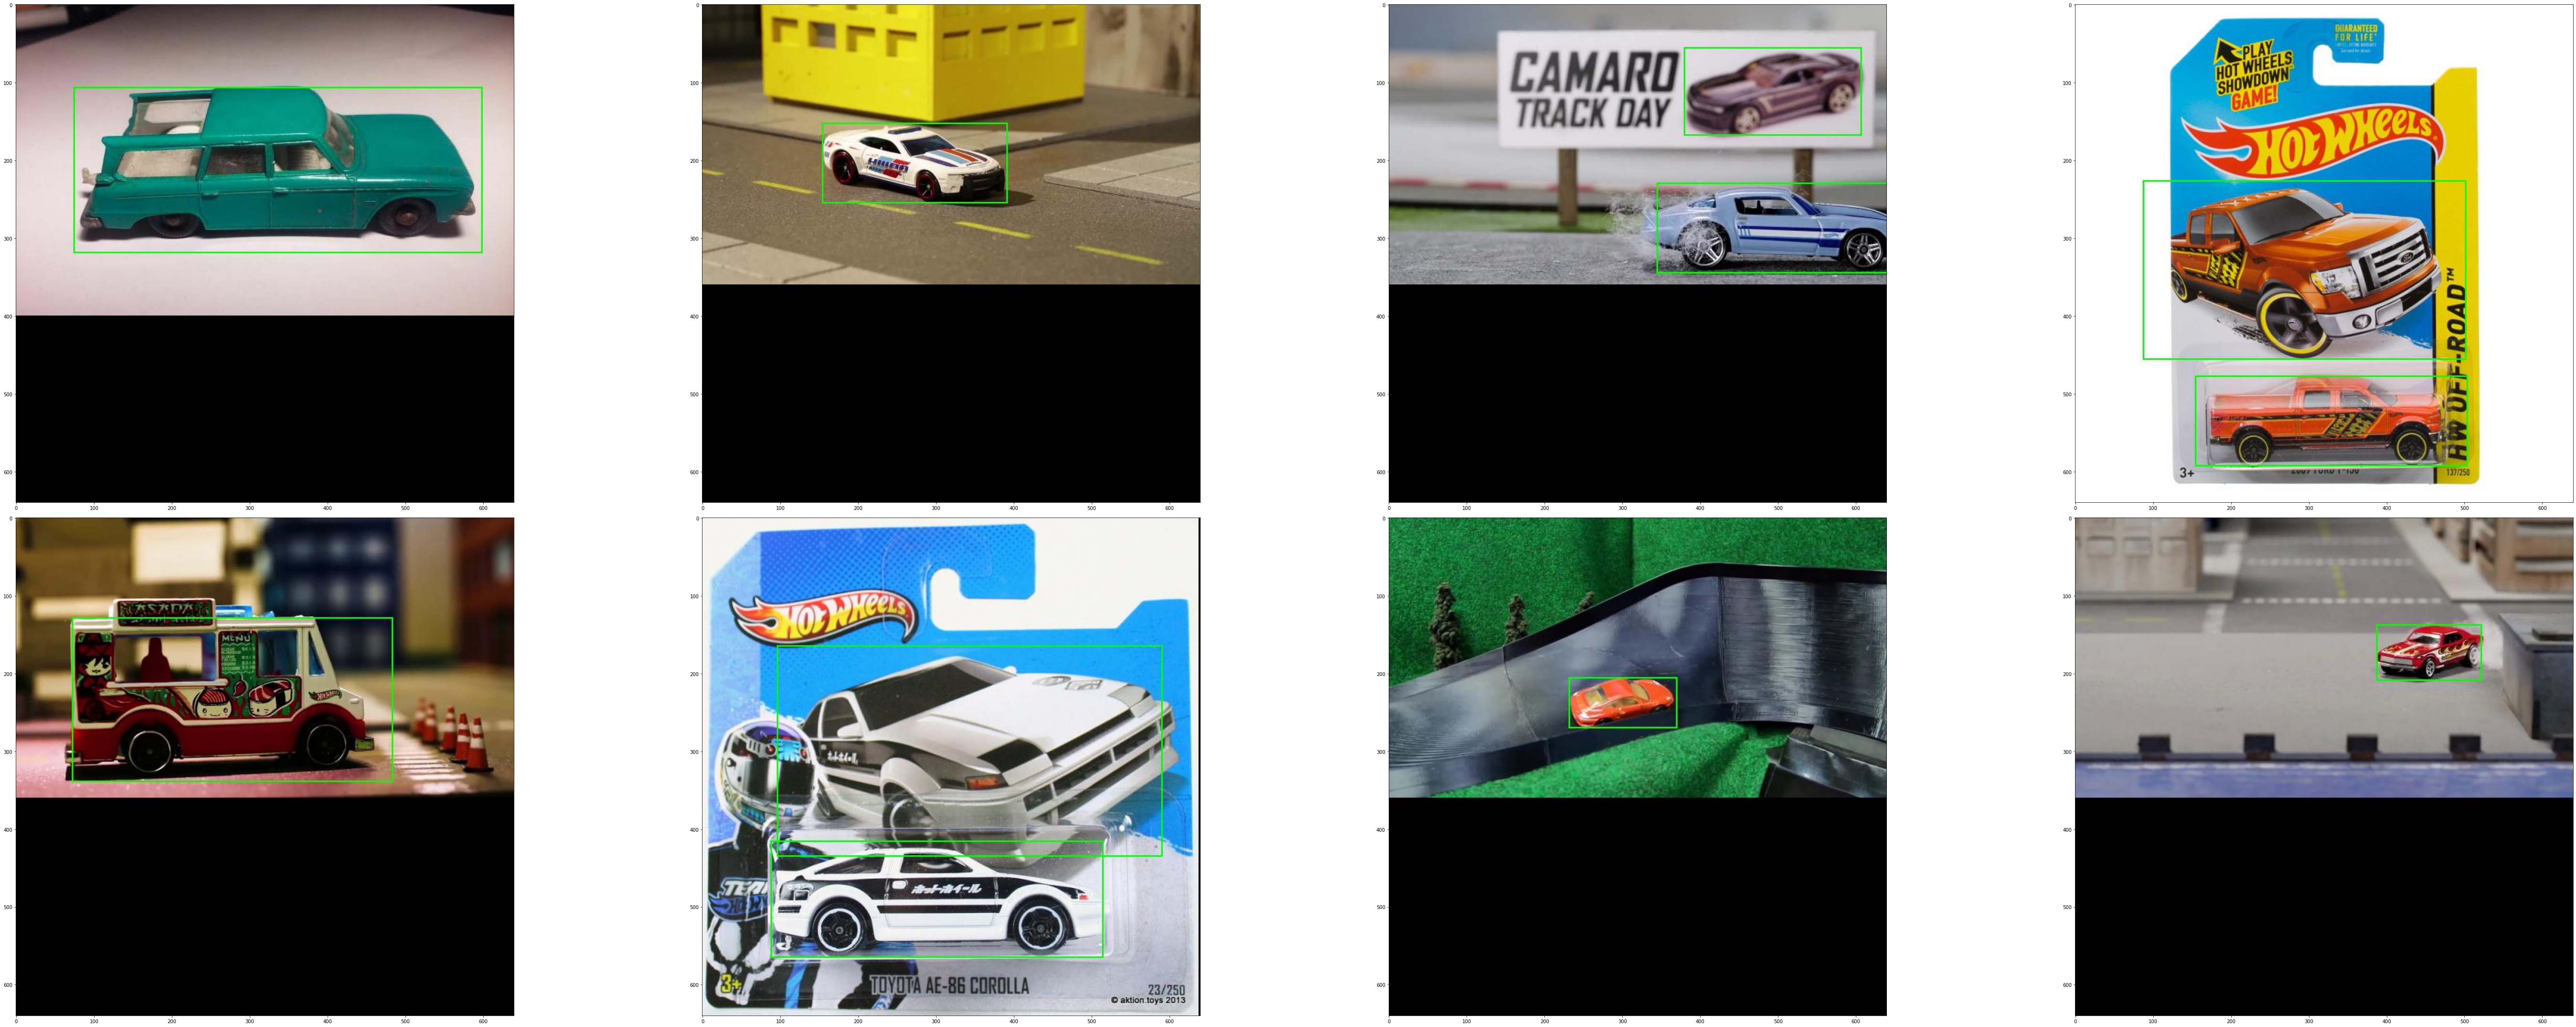

In [12]:
# Visualizing the first 12 images.
OUTPUT_PATH = 'tao_infer_testing/images_annotated' # relative path from $USER_EXPERIMENT_DIR.
COLS = 4 # number of columns in the visualizer grid.
IMAGES = 8 # number of images to visualize.

visualize_images(OUTPUT_PATH, num_cols=COLS, num_images=IMAGES)

## 10. Model Export

In [104]:
!mkdir -p $LOCAL_EXPERIMENT_DIR/experiment_dir_final
# Removing a pre-existing copy of the etlt if there has been any.
import os
output_file=os.path.join(os.environ['LOCAL_EXPERIMENT_DIR'],
                         "experiment_dir_final/resnet18_detector.etlt")
if os.path.exists(output_file):
    os.system("rm {}".format(output_file))


In [105]:
!docker run -it --rm --gpus $MIG_INDEX --name tao_exp_$USER \
-u $UID:$UID \
-v $LOCAL_DATA_DIR:/workspace/toy_car_detection/data \
-v $LOCAL_PROJECT_DIR:/workspace/toy_car_detection \
-v $LOCAL_SPECS_DIR:$SPECS_DIR \
nvcr.io/nvidia/tao/tao-toolkit-tf:v3.21.11-tf1.15.4-py3 \
detectnet_v2 export --gpu_index $GPU_INDEX\
    -m $USER_EXPERIMENT_DIR/experiment_dir_retrain/weights/resnet18_detector_pruned.tlt \
    -o $USER_EXPERIMENT_DIR/experiment_dir_final/resnet18_detector.etlt \
    -k $KEY

mkdir: cannot create directory ‘/opt/ngccli’: Permission denied
Matplotlib created a temporary config/cache directory at /tmp/matplotlib-7co9sk1j because the default path (/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.
Using TensorFlow backend.
Using TensorFlow backend.
2022-07-09 12:19:30,768 [INFO] root: Building exporter object.
2022-07-09 12:19:32,423 [INFO] root: Exporting the model.
2022-07-09 12:19:32,424 [INFO] root: Using input nodes: ['input_1']
2022-07-09 12:19:32,424 [INFO] root: Using output nodes: ['output_cov/Sigmoid', 'output_bbox/BiasAdd']
2022-07-09 12:19:32,424 [INFO] iva.common.export.keras_exporter: Using input nodes: ['input_1']
2022-07-09 12:19:32,424 [INFO] iva.common.export.keras_exporter: Using output nodes: ['output_cov/Sigmoid', 'output_bbox/BiasAdd']
/usr/local/lib/python3

In [106]:
print('Exported model:')
print('------------')
!ls -lh $LOCAL_EXPERIMENT_DIR/experiment_dir_final

Exported model:
------------
total 21M
-rw-r--r-- 1 stud22034803 stud22034803 21M Jul  9 20:19 resnet18_detector.etlt


### A. Int8 Optimization
- Calibrate the model to run 8-bit inferences -

In [107]:
!docker run -it --rm --gpus $MIG_INDEX --name tao_exp_$USER \
-u $UID:$UID \
-v $LOCAL_DATA_DIR:/workspace/toy_car_detection/data \
-v $LOCAL_PROJECT_DIR:/workspace/toy_car_detection \
-v $LOCAL_SPECS_DIR:$SPECS_DIR \
nvcr.io/nvidia/tao/tao-toolkit-tf:v3.21.11-tf1.15.4-py3 \
detectnet_v2 calibration_tensorfile --gpu_index $GPU_INDEX \
                                         -e $SPECS_DIR/detectnet_v2_retrain_resnet18_kitti.txt \
                                         -m 40 \
                                         -o $USER_EXPERIMENT_DIR/experiment_dir_final/calibration.tensor

mkdir: cannot create directory ‘/opt/ngccli’: Permission denied
Matplotlib created a temporary config/cache directory at /tmp/matplotlib-0rit3to2 because the default path (/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.
Using TensorFlow backend.
Using TensorFlow backend.
2022-07-09 12:28:18,921 [INFO] __main__: This method is soon to be deprecated. Please use the -e option in the export command to instantiate the dataloader and generate samples for calibration from the training dataloader.
2022-07-09 12:28:18,921 [INFO] iva.detectnet_v2.spec_handler.spec_loader: Merging specification from /workspace/toy_car_detection/detectnet_v2/specs/detectnet_v2_retrain_resnet18_kitti.txt

2022-07-09 12:28:18,926 [WARNING] tensorflow: From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:15

In [108]:
!rm -rf $LOCAL_EXPERIMENT_DIR/experiment_dir_final/resnet18_detector.etlt
!rm -rf $LOCAL_EXPERIMENT_DIR/experiment_dir_final/calibration.bin
!docker run -it --rm --gpus $MIG_INDEX --name tao_exp_$USER \
-u $UID:$UID \
-v $LOCAL_DATA_DIR:/workspace/toy_car_detection/data \
-v $LOCAL_PROJECT_DIR:/workspace/toy_car_detection \
-v $LOCAL_SPECS_DIR:$SPECS_DIR \
nvcr.io/nvidia/tao/tao-toolkit-tf:v3.21.11-tf1.15.4-py3 \
detectnet_v2 export --gpu_index $GPU_INDEX \
                  -m $USER_EXPERIMENT_DIR/experiment_dir_retrain/weights/resnet18_detector_pruned.tlt \
                  -o $USER_EXPERIMENT_DIR/experiment_dir_final/resnet18_detector.etlt \
                  -k $KEY  \
                  --cal_data_file $USER_EXPERIMENT_DIR/experiment_dir_final/calibration.tensor \
                  --data_type int8 \
                  --batches 20 \
                  --batch_size 4 \
                  --max_batch_size 4\
                  --engine_file $USER_EXPERIMENT_DIR/experiment_dir_final/resnet18_detector.trt.int8 \
                  --cal_cache_file $USER_EXPERIMENT_DIR/experiment_dir_final/calibration.bin \
                  --verbose

mkdir: cannot create directory ‘/opt/ngccli’: Permission denied
Matplotlib created a temporary config/cache directory at /tmp/matplotlib-rnqmcz2u because the default path (/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.
Using TensorFlow backend.
Using TensorFlow backend.
2022-07-09 12:29:34,023 [INFO] root: Building exporter object.
2022-07-09 12:29:35,680 [INFO] root: Exporting the model.
2022-07-09 12:29:35,680 [INFO] root: Using input nodes: ['input_1']
2022-07-09 12:29:35,680 [INFO] root: Using output nodes: ['output_cov/Sigmoid', 'output_bbox/BiasAdd']
2022-07-09 12:29:35,680 [INFO] iva.common.export.keras_exporter: Using input nodes: ['input_1']
2022-07-09 12:29:35,680 [INFO] iva.common.export.keras_exporter: Using output nodes: ['output_cov/Sigmoid', 'output_bbox/BiasAdd']
/usr/local/lib/python3

### B. Generate TensorRT engine
- Verify engine generation using the `tao-converter` utility included with the docker.

In [109]:
!docker run -it --rm --gpus $MIG_INDEX --name tao_exp_$USER \
-u $UID:$UID \
-v $LOCAL_DATA_DIR:/workspace/toy_car_detection/data \
-v $LOCAL_PROJECT_DIR:/workspace/toy_car_detection \
-v $LOCAL_SPECS_DIR:$SPECS_DIR \
nvcr.io/nvidia/tao/tao-toolkit-tf:v3.21.11-tf1.15.4-py3 \
converter $USER_EXPERIMENT_DIR/experiment_dir_final/resnet18_detector.etlt --gpu_index $GPU_INDEX\
    -k $KEY \
    -c $USER_EXPERIMENT_DIR/experiment_dir_final/calibration.bin \
    -o output_cov/Sigmoid,output_bbox/BiasAdd \
    -d 3,544,960 \
    -i nchw \
    -m 64 \
    -t int8 \
    -e $USER_EXPERIMENT_DIR/experiment_dir_final/resnet18_detector.trt \
    -b 4

mkdir: cannot create directory ‘/opt/ngccli’: Permission denied
converter: invalid option -- '-'
Unrecognized argument
/usr/local/bin/install_ngc_cli.sh: line 27:     8 Aborted                 (core dumped) converter /workspace/toy_car_detection/detectnet_v2/experiment_dir_final/resnet18_detector.etlt --gpu_index 0 -k tlt_encode -c /workspace/toy_car_detection/detectnet_v2/experiment_dir_final/calibration.bin -o output_cov/Sigmoid,output_bbox/BiasAdd -d 3,544,960 -i nchw -m 64 -t int8 -e /workspace/toy_car_detection/detectnet_v2/experiment_dir_final/resnet18_detector.trt -b 4


## 11. Verify Deployed Model
- Verify the exported model by visualizing inferences on TensorRT.

### A. Inference using TensorRT engine <a class="anchor" id="head-11-1"></a>

In [110]:
!docker run -it --rm --gpus $MIG_INDEX --name tao_exp_$USER \
-u $UID:$UID \
-v $LOCAL_DATA_DIR:/workspace/toy_car_detection/data \
-v $LOCAL_PROJECT_DIR:/workspace/toy_car_detection \
-v $LOCAL_SPECS_DIR:$SPECS_DIR \
nvcr.io/nvidia/tao/tao-toolkit-tf:v3.21.11-tf1.15.4-py3 \
detectnet_v2 inference --gpu_index $GPU_INDEX \
    -e $SPECS_DIR/detectnet_v2_inference_kitti_etlt.txt \
    -o $USER_EXPERIMENT_DIR/etlt_infer_testing \
    -i $DATA_DOWNLOAD_DIR/test \
    -k $KEY

mkdir: cannot create directory ‘/opt/ngccli’: Permission denied
Matplotlib created a temporary config/cache directory at /tmp/matplotlib-ofglc3xd because the default path (/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.
Using TensorFlow backend.
Using TensorFlow backend.
2022-07-09 12:36:30,172 [INFO] iva.detectnet_v2.spec_handler.spec_loader: Merging specification from /workspace/toy_car_detection/detectnet_v2/specs/detectnet_v2_inference_kitti_etlt.txt
2022-07-09 12:36:30,174 [INFO] __main__: Creating output inference directory
2022-07-09 12:36:30,174 [INFO] __main__: Overlain images will be saved in the output path.
2022-07-09 12:36:30,174 [INFO] iva.detectnet_v2.inferencer.build_inferencer: Constructing inferencer
2022-07-09 12:36:30,623 [INFO] iva.detectnet_v2.inferencer.trt_inferencer: Engine fil